<a href="https://colab.research.google.com/github/Izyakowich/BKIT/blob/main/mephi_project_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Устанавливаем и импортируем библиотеки

In [1]:
!pip install supervision opencv-python pillow matplotlib
!pip install inference-sdk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.4/212.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.12.0.88
    Uninstalling opencv-python-4.12.0.88:
      Successfully uninstalled opencv-python-4.12.0.88
  Attempting uninstall: aiohttp
    Found existing installation: aiohttp 3.13.2
    Uninstalling aiohttp-3.13.2:
      Successfully uninstalled aiohttp-3.13.2


In [7]:
import cv2
import supervision as sv
import numpy as np
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
from inference_sdk import InferenceHTTPClient
from collections import Counter

## Несколько картинок для проверки работоспособности модели

In [112]:
'''
При необходимости можно добавить ссылку на любую другую картинку
Чем выше качество картинки, тем качественнее будет обнаружение мусора
'''
image_url1 = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSpQow0xw3cAzLuyHyVmcmIwOc-3PjRn9ko7g&s"
image_url2 = "https://domodedovod.ru/uploads/2013/07/musorka-4713.jpg"
image_url3 = "https://mayaksbor.ru/upload/iblock/d7f/d7f10430c429c945dfeb617a4ca6ab74.jpg"


image_urls = [                    # создаем массив урлов
    image_url1,
    image_url2,
    image_url3
]

## Инициализируем клиента

In [34]:
API_KEY = "API_KEY"               # тут можно вставить ваш ключ, чтобы иметь возможность запускать модель
WORKSPACE = "izyakowich"          # рабочее пространство
WORKFLOW  = "custom-workflow-4"   # модель для обнаружения мусора

client = InferenceHTTPClient(     # инициализация клиента Roboflow
    api_url="https://serverless.roboflow.com",
    api_key=API_KEY
)

In [113]:
'''
На данном шаге происходит отправка изображений на сервер для дальнейшей обработки
'''

result = client.run_workflow(
    workspace_name=WORKSPACE,
    workflow_id=WORKFLOW,
    images={"image": image_url1},
    use_cache=False
)

## Функция обработки изображения

In [114]:

def process_image(url):
    '''
    Передаём одну картинку в workflow.
    Возвращается список результатов, как правило один элемент
    '''
    result = client.run_workflow(
        workspace_name=WORKSPACE,
        workflow_id=WORKFLOW,
        images={"image": url},
        use_cache=False
    )



    # Загружаем картинку по урлу
    response = requests.get(url)
    '''
    Открываем изображение и ковертируем в RGB, для гарантии,
    что изображение имеет стандартный цветовой формат
    '''
    image_pil = Image.open(BytesIO(response.content)).convert("RGB")
    '''
    Преобразовываем в numpy-массив, тк Supervision может работать
    только с массивами
    '''
    image_np = np.array(image_pil)



    # Обрабатываем предсказания
    prediction_data = result[0] # Берем первое значение, тк отправляли одно изображение

    # Конвертируем в формат Supervision
    detections = sv.Detections.from_inference(prediction_data["predictions"])

    # Аннотаторы для рамок и подписей, а так же генерация подписей
    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()
    labels = [
        f"{cls} {conf:.2f}"
        for cls, conf in zip(detections.data["class_name"], detections.confidence)
    ]

    # Рисуем bounding boxes
    annotated = box_annotator.annotate(
        image_np.copy(), detections
        )

    # Рисуем текстовые подписи над объектами
    annotated = label_annotator.annotate(
        annotated, detections, labels
        )



    # Формируем текстовый вывод
    total = len(detections)     # Количество детекций


    if total > 0:
        # Получаем список всех распознанных классов
        class_names = detections.data["class_name"]

        # Считаем, какой тип мусора встречается чаще всего
        most_common = Counter(class_names).most_common(1)[0][0]
        msg = (
            f"Обнаружено объектов: {total}. "
            f"Чаще всего встречается класс: {most_common}."
        )
    else:
        msg = "Мусор не обнаружен."


    # Возвращаем обработанное изображение + текстовый результат
    return annotated, msg


## Ниже проверим работоспособность выбранной модели на реальных фото из интернета

Обнаружено объектов: 1. Чаще всего встречается класс: sampah.


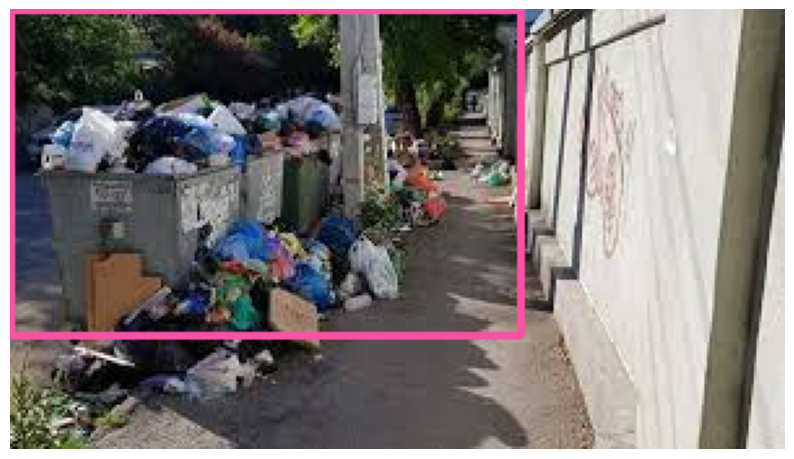

In [115]:
image_index = 0
annotated, msg = process_image(image_urls[image_index])
print(msg)

plt.figure(figsize=(10, 10))
plt.imshow(annotated)
plt.axis("off")
plt.show()



Обнаружено объектов: 1. Чаще всего встречается класс: sampah.


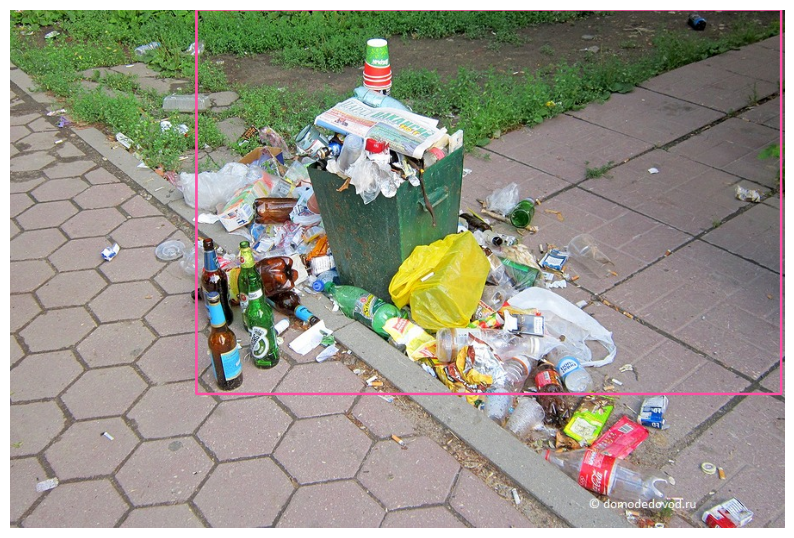

In [64]:
image_index = 1
annotated, msg = process_image(image_urls[image_index])
print(msg)

plt.figure(figsize=(10, 10))
plt.imshow(annotated)
plt.axis("off")
plt.show()


Обнаружено объектов: 1. Чаще всего встречается класс: sampah.


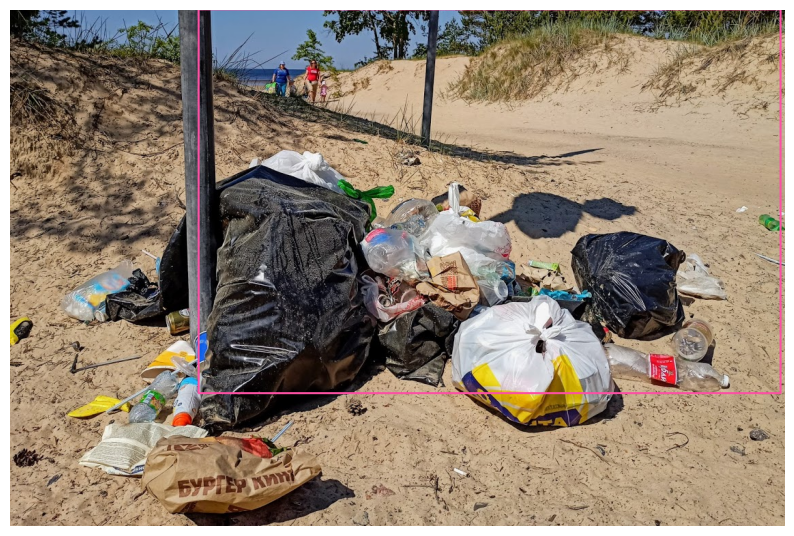

In [63]:
image_index = 2
annotated, msg = process_image(image_urls[image_index])
print(msg)

plt.figure(figsize=(10, 10))
plt.imshow(annotated)
plt.axis("off")
plt.show()
